I will be solving the problem shown using the [Nutils](http://www.nutils.org/en/latest/) Finite Element programming library.

The strong form of the equation is 
$$ - \nabla\cdot\left( D \nabla \phi_0\right) \,+\, \Sigma_a\, \phi_0 = Q_0 $$ where $D = \frac{1}{3\Sigma_t}\,$ and $\,\Sigma_a = \Sigma_t - \Sigma_s^0$

To solve the problem using the Galerkin method, we work with the weak form given by: $$ \int_{\Omega}D \,\nabla N_A \,\cdot\,\nabla \phi_0 \, dx - \int_{\partial \Omega}N_A D\nabla \phi_0 \cdot\hat{n} \, ds  + \int_{\Omega} N_A \, \Sigma_a \phi_0\,dx = \int_{\Omega} N_A\, Q_0 \, dx $$ 

where $N_A$ is a basis function over the mesh and $\phi_0 = \sum_A c_A N_A$. For this problem, we use either vacuum boundary condition ($\phi_0 = 0$ on $\partial \Omega$) or reflecting boundary condition ($\hat{n} \cdot \nabla \phi_0 = 0$). In both cases, the Galerkin weak form simplifies to 

$$ \int_{\Omega}D \,\nabla N_A \,\cdot\,\nabla \phi_0 \, dx  + \int_{\Omega} N_A \, \Sigma_a \phi_0\,dx = \int_{\Omega} N_A\, Q_0 \, dx $$ 

This is the weak form we will use in the code below


solve > solving 1681 dof system to machine precision using arnoldi solver
solve > solver returned with residual 1e-14


<IPython.core.display.Javascript object>


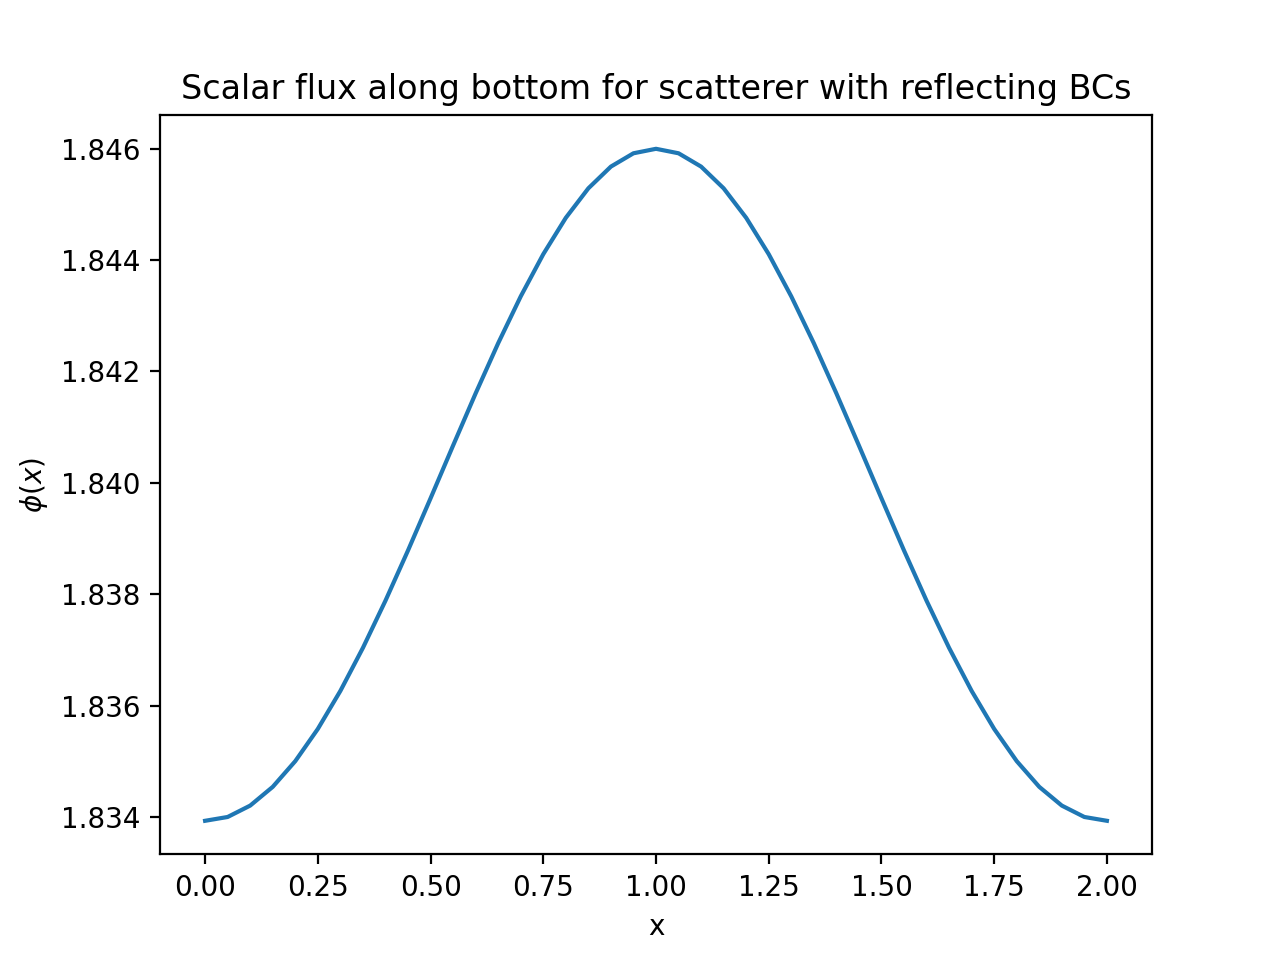

<IPython.core.display.Javascript object>


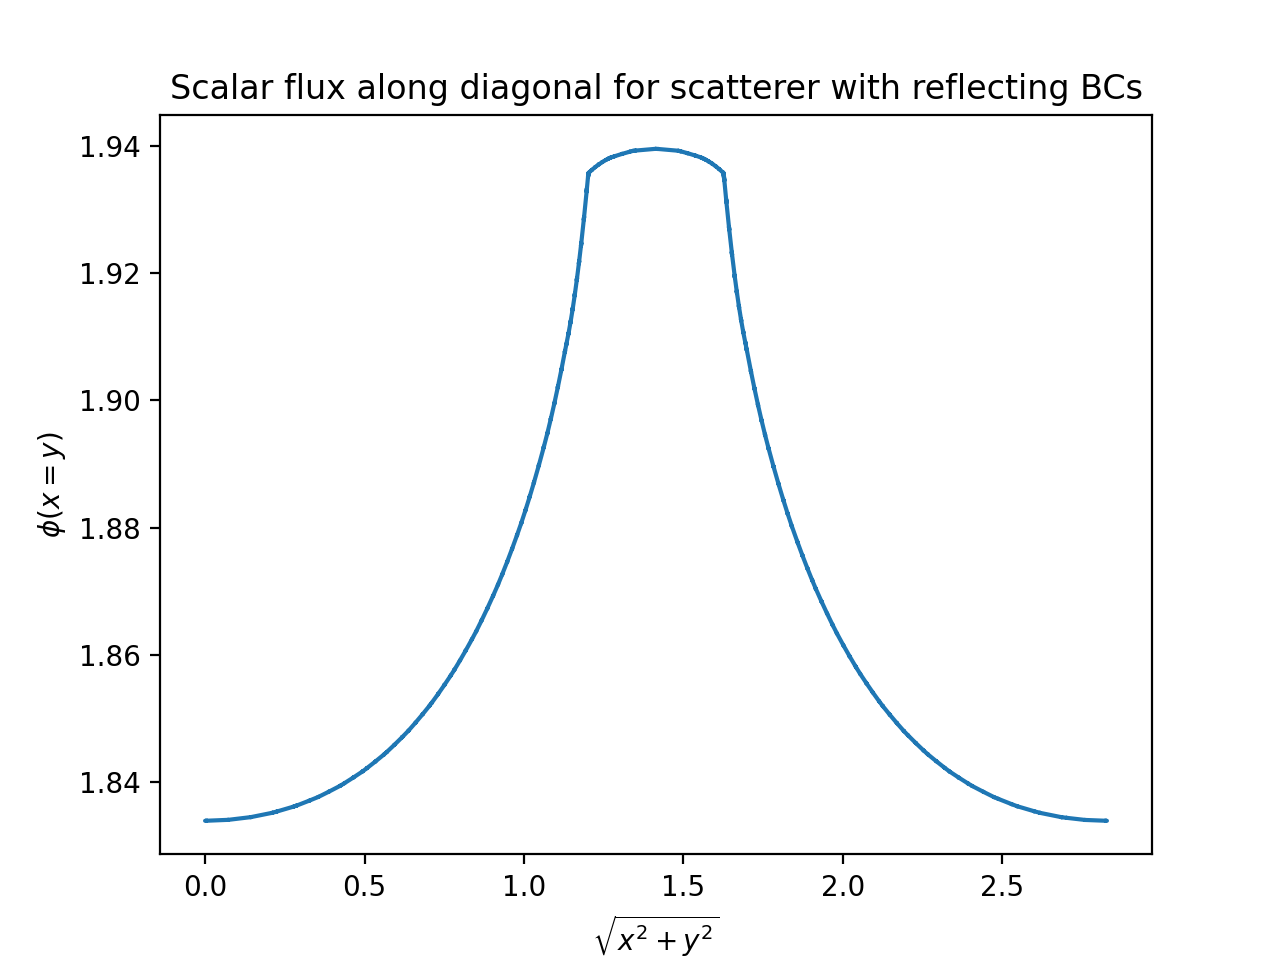

Text(0, 0.5, '$\\phi(x = y)$')

In [1]:
from nutils import function, mesh, solver, topology, element
import matplotlib.pyplot as plt

%matplotlib notebook

degree = 1 #degree of basis functions

W = 2 #width of outer box
Wi = .3 #width of inner box
nelems = int(20 * W) #number of elements along edge of unit square

mat_flag = 'scatterer' #TYPE OF MATERIAL IN OUTER BOX. OTHER POSSIBILITIES: 'reflector' 'absorber' 'air'
if mat_flag == 'scatterer':
    sigt = 2
    sigs = 1.99
elif mat_flag == 'reflector':
    sigt = 2
    sigs = 1.8
elif mat_flag == 'absorber':
    sigt = 10
    sigs = 2
elif mat_flag == 'air':
    sigt = .01
    sigs = .006
    
BC_flag = 'reflecting' #TYPE OF BOUNDARY CONDITION. OPTIONS ARE: 'vacuum' 'reflecting'
    
topo, geom = mesh.unitsquare(nelems, 'square') #unit square centred at (0.5, 0.5)
ns = function.Namespace()
ns.basis = topo.basis('lagrange', degree = degree)

ns.W = W
#ns.Wi = Wi

ns.x = W * (geom ) #scales the unit square to our physical square
ns.f =function.max(function.abs(ns.x[0] -  W/2), function.abs(ns.x[1] - W/2)) #level set function for inner square 
# 'max( abs(x_0 - W / 2), abs( x_1 - W / 2) )' 
inner, outer = function.partition(ns.f, Wi / 2) #indicator function for inner square and outer square

ns.phi = 'basis_A ?dofs_A'
ns.SIGs  = sigs * outer              #scattering cross-section
ns.SIGt  = 0.1 * inner + sigt* outer              #total cross-section
ns.SIGa = 'SIGt - SIGs' #absorption cross-section
ns.D = '1 / (3 SIGt)'   #diffusion co-efficient
ns.Q =  inner  #source term

if BC_flag == 'vacuum':
    sqr = topo.boundary.integral('(phi - 0)^2 J(x)' @ns, degree = degree * 2)
    cons = solver.optimize('dofs', sqr, droptol=1e-14) #this applies the boundary condition to u
    #residual
    res = topo.integral( '(D basis_i,j phi_,j + SIGa basis_i phi - basis_i Q) J(x)' @ ns, degree = degree * 2) 
    #solve for degrees of freedom
    dofs = solver.solve_linear('dofs', res, constrain = cons)
    
elif BC_flag == 'reflecting':
    #residual
    res = topo.integral( '(D basis_i,j phi_,j + SIGa basis_i phi - basis_i Q) J(x)' @ ns, degree = degree * 2)   
    #solve for degrees of freedom
    dofs = solver.solve_linear('dofs', res)

#select lower triangular half of square domain. Diagonal is one of its boundaries
triang = topo.trim('x_0 - x_1' @ns, maxrefine=5)
triangbnd = triang.boundary #select boundary of lower triangle 

# eval the vertices of the boundary elements of lower triangle:
verts = triangbnd.sample(*element.parse_legacy_ischeme("vertex")).eval('x_i' @ns)

# now select the verts of the boundary
diag = topology.SubsetTopology(triangbnd, [triangbnd.references[i]
                                                    if (verts[2*i][0] == verts[2*i][1] and verts[2*i+1][0] ==
                                                        verts[2*i+1][1] ) else triangbnd.references[i].empty 
                                           for i in range(len(triangbnd.references))])


bezier_diag = diag.sample('bezier', degree + 1)
x_diag = bezier_diag.eval('(x_0^2 + x_1^2)^(1 / 2)' @ns)
phi_diag = bezier_diag.eval('phi' @ ns, dofs = dofs)

bezier_bottom = topo.boundary['bottom'].sample('bezier', degree + 1)
x_bottom = bezier_bottom.eval('x_0' @ns)
phi_bottom = bezier_bottom.eval('phi' @ns, dofs = dofs)

fig_bottom = plt.figure()
ax_bottom = fig_bottom.add_subplot(111) 
plt.plot(x_bottom, phi_bottom)
ax_bottom.set_title('Scalar flux along bottom for %s with %s BCs'%(mat_flag, BC_flag))
ax_bottom.set_xlabel('x')
ax_bottom.set_ylabel('$\\phi(x)$')
plt.savefig('bottom_flux.png')

fig_diag = plt.figure()
ax_diag = fig_diag.add_subplot(111)
plt.plot(x_diag, phi_diag)
ax_diag.set_title('Scalar flux along diagonal for %s with %s BCs'%(mat_flag, BC_flag))
ax_diag.set_xlabel('$\\sqrt{x^2 + y^2}$')
ax_diag.set_ylabel('$\\phi(x = y)$')


solve > solving 2601 dof system to machine precision using arnoldi solver
solve > solver returned with residual 9e-15
(<Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>)


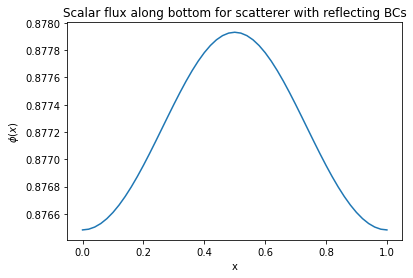

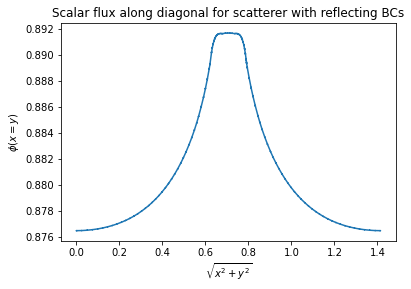

In [2]:
from nutils import function, mesh, solver, topology, element
import matplotlib.pyplot as plt

def neutrondiffusion(mat_flag = 'scatterer', BC_flag = 'vacuum',bigsquare = 1, smallsquare = .1, degree = 2):
                     
    W = bigsquare #width of outer box
    Wi = smallsquare #width of inner box

    nelems = int(25 *W) #25 elements per unit distance
    
    if mat_flag == 'scatterer':
        sigt = 2
        sigs = 1.99
    elif mat_flag == 'reflector':
        sigt = 2
        sigs = 1.8
    elif mat_flag == 'absorber':
        sigt = 10
        sigs = 2
    elif mat_flag == 'air':
        sigt = .01
        sigs = .006
    
    topo, geom = mesh.unitsquare(nelems, 'square') #unit square centred at (0.5, 0.5)
    ns = function.Namespace()
    ns.basis = topo.basis('lagrange', degree = degree)
    
    ns.x = W * geom #scales the unit square to our physical square
    ns.f =function.max(function.abs(ns.x[0] -  W/2), function.abs(ns.x[1] - W/2)) #level set function for inner square 
    
    inner, outer = function.partition(ns.f, Wi / 2) #indicator function for inner square and outer square

    ns.phi = 'basis_A ?dofs_A'
    ns.SIGs  = sigs * outer              #scattering cross-section
    ns.SIGt  = 0.1 * inner + sigt* outer              #total cross-section
    ns.SIGa = 'SIGt - SIGs' #absorption cross-section
    ns.D = '1 / (3 SIGt)'   #diffusion co-efficient
    ns.Q =  inner #source term

    if BC_flag == 'vacuum':
        sqr = topo.boundary.integral('(phi - 0)^2 J(x)' @ns, degree = degree * 2)
        cons = solver.optimize('dofs', sqr, droptol=1e-14) #this applies the boundary condition to u
    
        #residual
        res = topo.integral( '(D basis_i,j phi_,j + SIGa basis_i phi - basis_i Q) J(x)' @ ns, degree = degree * 2) 
    
        #solve for degrees of freedom
        dofs = solver.solve_linear('dofs', res, constrain = cons)
    
    elif BC_flag == 'reflecting':
        #residual
        res = topo.integral( '(D basis_i,j phi_,j + SIGa basis_i phi - basis_i Q) J(x)' @ ns, degree = degree * 2) 
        
        #solve for degrees of freedom
        dofs = solver.solve_linear('dofs', res)
    
    #select lower triangular half of square domain. Diagonal is one of its boundaries
    triang = topo.trim('x_0 - x_1' @ns, maxrefine=5)
    triangbnd = triang.boundary #select boundary of lower triangle 
    # eval the vertices of the boundary elements of lower triangle:
    verts = triangbnd.sample(*element.parse_legacy_ischeme("vertex")).eval('x_i' @ns)
    # now select the verts of the boundary
    diag = topology.SubsetTopology(triangbnd, [triangbnd.references[i]
                                               if (verts[2*i][0] == verts[2*i][1] and verts[2*i+1][0] == verts[2*i+1][1] )
                                               else triangbnd.references[i].empty
                                               for i in range(len(triangbnd.references))])
    bezier_diag = diag.sample('bezier', degree + 1)
    x_diag = bezier_diag.eval('(x_0^2 + x_1^2)^(1 / 2)' @ns)
    phi_diag = bezier_diag.eval('phi' @ ns, dofs = dofs)
    
    bezier_bottom = topo.boundary['bottom'].sample('bezier', degree + 1)
    x_bottom = bezier_bottom.eval('x_0' @ns)
    phi_bottom = bezier_bottom.eval('phi' @ns, dofs = dofs)
    
    fig_bottom = plt.figure(0)
    ax_bottom = fig_bottom.add_subplot(111) 
    ax_bottom.plot(x_bottom, phi_bottom)
    ax_bottom.set_title('Scalar flux along bottom for %s with %s BCs'%(mat_flag, BC_flag))
    ax_bottom.set_xlabel('x')
    ax_bottom.set_ylabel('$\\phi(x)$')
    
    
    fig_diag = plt.figure(1)
    ax_diag = fig_diag.add_subplot(111)
    ax_diag.plot(x_diag, phi_diag)
    ax_diag.set_title('Scalar flux along diagonal for %s with %s BCs'%(mat_flag, BC_flag))
    ax_diag.set_xlabel('$\\sqrt{x^2 + y^2}$')
    ax_diag.set_ylabel('$\\phi(x = y)$')
    
    return fig_bottom, fig_diag


fig = neutrondiffusion(mat_flag= 'scatterer', BC_flag= 'reflecting');
print(fig)
#plt.savefig('bottom.png')


#plt.show(ax[0])

In [5]:
print(fig[0].number)
plt.figure(0)

0


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [6]:
help(plt.figure)

Help on function figure in module matplotlib.pyplot:

figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)
    Create a new figure, or activate an existing figure.
    
    Parameters
    ----------
    num : int or str, optional
        A unique identifier for the figure.
    
        If a figure with that identifier already exists, this figure is made
        active and returned. An integer refers to the ``Figure.number``
        attribute, a string refers to the figure label.
    
        If there is no figure with the identifier or *num* is not given, a new
        figure is created, made active and returned.  If *num* is an int, it
        will be used for the ``Figure.number`` attribute, otherwise, an
        auto-generated integer value is used (starting at 1 and incremented
        for each new figure). If *num* is a string, the figure label and the
        window title is s